In [28]:
# 2D Spiral Dataset Clustering Test
# Setup: Import libraries and configure environment

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Setup Python path to import from project root
sys.path.append(os.path.abspath('..'))

# Import core libraries
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

# Import KL clustering modules
from kl_clustering_analysis.tree.poset_tree import PosetTree
from kl_clustering_analysis import config
from kl_clustering_analysis.plot.cluster_tree_visualization import plot_tree_with_clusters

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [13]:
# Define Spiral Dataset Generator

def create_spiral_dataset(n_samples=200, n_spirals=3, noise=0.1, seed=42):
    """
    Create a spiral dataset that's challenging for traditional clustering.
    
    Parameters
    ----------
    n_samples : int
        Number of samples to generate
    n_spirals : int
        Number of spiral arms
    noise : float
        Standard deviation of gaussian noise
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    data : pd.DataFrame
        Binarized feature matrix
    y_true : np.ndarray
        True spiral labels
    X : np.ndarray
        Original 2D coordinates
    """
    np.random.seed(seed)

    # Create spiral arms
    t = np.linspace(0, 4*np.pi, n_samples//n_spirals)
    spirals = []

    for i in range(n_spirals):
        # Create spiral coordinates
        r = t / (4*np.pi)  # radius increases with angle
        x = r * np.cos(t + i * 2*np.pi/n_spirals)
        y = r * np.sin(t + i * 2*np.pi/n_spirals)

        # Add noise
        x += np.random.normal(0, noise, len(x))
        y += np.random.normal(0, noise, len(y))

        spirals.append(np.column_stack([x, y]))

    # Combine all spirals
    X = np.vstack(spirals)

    # Create binary features (binarize)
    X_binary = (X > np.median(X, axis=0)).astype(int)
    data = pd.DataFrame(
        X_binary,
        index=[f"S{j}" for j in range(len(X))],
        columns=[f"F{j}" for j in range(X.shape[1])],
    )

    # True labels (which spiral each point belongs to)
    y_true = np.repeat(range(n_spirals), n_samples//n_spirals)

    return data, y_true, X

print("✓ Dataset generator function defined")


✓ Dataset generator function defined


In [21]:
# Generate Spiral Data

print("Generating 2D spiral dataset...")
spiral_data, spiral_labels, spiral_coords = create_spiral_dataset(
    n_samples=150, 
    n_spirals=3, 
    noise=0.05
)

print(f"✓ Dataset generated:")
print(f"  - Samples: {len(spiral_data)}")
print(f"  - Features: {spiral_data.shape[1]}")
print(f"  - True clusters: 3 spirals")
print(f"  - Data shape: {spiral_data.shape}")


Generating 2D spiral dataset...
✓ Dataset generated:
  - Samples: 150
  - Features: 2
  - True clusters: 3 spirals
  - Data shape: (150, 2)


In [22]:
# Build Hierarchical Tree and Run Clustering

print("Building hierarchical tree...")
Z_spiral = linkage(pdist(spiral_data.values, metric="hamming"), method="complete")
tree_spiral = PosetTree.from_linkage(Z_spiral, leaf_names=spiral_data.index.tolist())

print("Running KL-based cluster decomposition...")
result_spiral = tree_spiral.decompose(
    leaf_data=spiral_data,
    alpha_local=config.ALPHA_LOCAL,
    sibling_alpha=config.SIBLING_ALPHA,
)

# Extract the results_df that was computed internally
results_df_spiral = tree_spiral.stats_df

print(f"✓ Clustering complete:")
print(f"  - Clusters found: {result_spiral['num_clusters']}")


Building hierarchical tree...
Running KL-based cluster decomposition...
✓ Clustering complete:
  - Clusters found: 4


In [24]:
# Create Report DataFrame

# Create report dataframe from cluster assignments
cluster_assignments = result_spiral.get("cluster_assignments", {})

# Debug: Check decomposition results structure
print(f"\n{'='*60}")
print("DEBUG: Decomposition Results Analysis")
print(f"{'='*60}")
print(f"Number of clusters found: {result_spiral['num_clusters']}")
print(f"Cluster assignments dict keys: {list(cluster_assignments.keys())}")



# Check if tree nodes have labels
first_node = list(tree_spiral.nodes())[0]
node_attrs = tree_spiral.nodes[first_node] if hasattr(tree_spiral, "nodes") else {}

if cluster_assignments:
    rows = []
    for cid, info in cluster_assignments.items():
        for leaf in info["leaves"]:
            rows.append({
                "sample_id": leaf,
                "cluster_id": cid,
                "cluster_size": info["size"],
            })
    report_spiral = pd.DataFrame(rows).set_index("sample_id")
else:
    report_spiral = pd.DataFrame(columns=["cluster_id", "cluster_size"]).set_index("sample_id")




DEBUG: Decomposition Results Analysis
Number of clusters found: 4
Cluster assignments dict keys: [0, 1, 2, 3]



DEBUG: Cluster Label Analysis
Unique cluster labels: [0 1 2 3]
Number of unique labels: 4
Label counts:
  Label 0: 37 samples
  Label 1: 38 samples
  Label 2: 37 samples
  Label 3: 38 samples
✓ Plotting with cluster-based colors (tab10 colormap)


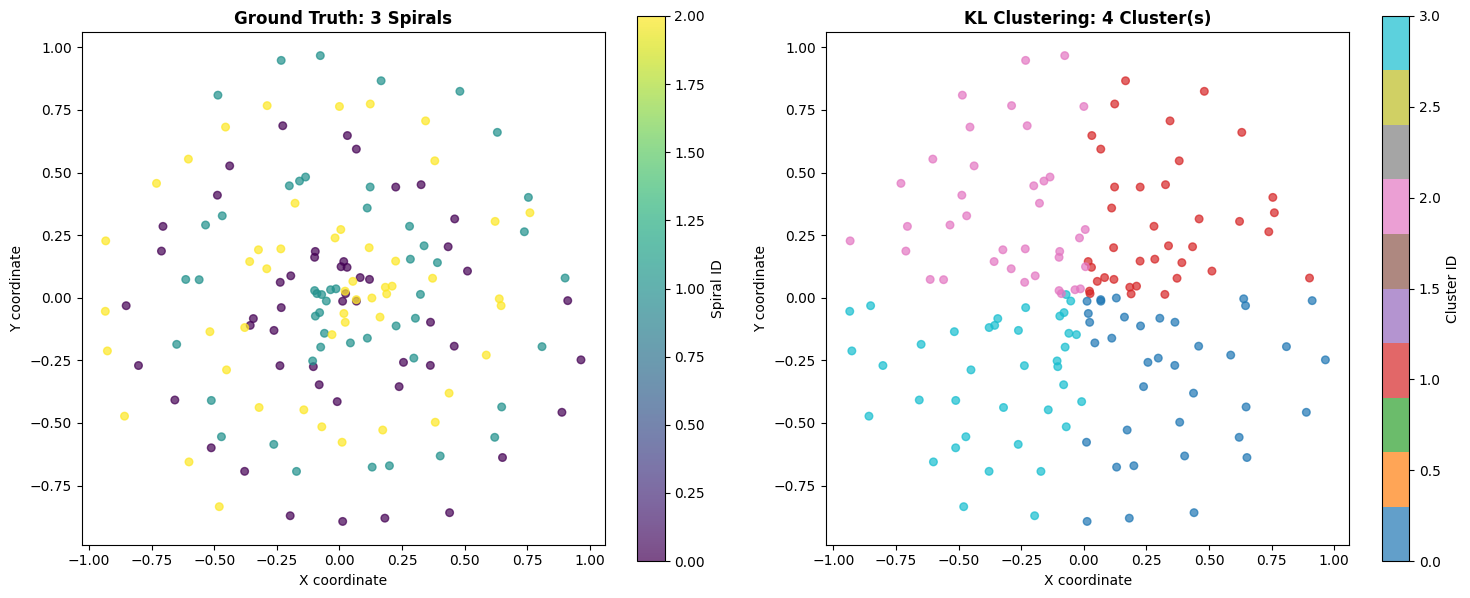


✓ Visualization complete


In [ ]:
# Visualize Results in 2D

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Ground truth
scatter1 = ax1.scatter(
    spiral_coords[:, 0], spiral_coords[:, 1], 
    c=spiral_labels, cmap='viridis', alpha=0.7, s=30
)
ax1.set_title('Ground Truth: 3 Spirals', fontsize=12, fontweight='bold')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
ax1.set_aspect('equal')
plt.colorbar(scatter1, ax=ax1, label='Spiral ID')

# Plot 2: Clustering result
# Use the same approach as validate_cluster_algorithm: extract labels from decomposition
def labels_from_decomposition(decomposition, sample_index):
    """Extract cluster labels for each sample from decomposition result."""
    assignments = {sample: -1 for sample in sample_index}
    for cluster_id, info in decomposition.get("cluster_assignments", {}).items():
        for leaf in info["leaves"]:
            assignments[leaf] = cluster_id
    return [assignments[sample] for sample in sample_index]

# Get cluster labels in the same order as spiral_data
sample_names = spiral_data.index.tolist()
cluster_labels = labels_from_decomposition(result_spiral, sample_names)

# Convert to numpy array for plotting
cluster_labels_array = np.array(cluster_labels)

unique, counts = np.unique(cluster_labels_array, return_counts=True)

# Plot with cluster colors (use tab10 for better color distinction)
if result_spiral['num_clusters'] > 1 and len(set(cluster_labels)) > 1:
    # Multiple clusters found and assigned
    scatter2 = ax2.scatter(
        spiral_coords[:, 0], spiral_coords[:, 1], 
        c=cluster_labels_array, cmap='tab10', alpha=0.7, s=30
    )

ax2.set_title(f'KL Clustering: {result_spiral["num_clusters"]} Cluster(s)', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
ax2.set_aspect('equal')
plt.colorbar(scatter2, ax=ax2, label='Cluster ID')

plt.tight_layout()
plt.savefig('../cluster_tree_plots/spiral_clustering_test.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization complete")


DEBUG: Cluster Color Mapping
Number of clusters: 4

Color mapping for each cluster ID:
  Cluster 0: #440154
  Cluster 1: #440256
  Cluster 2: #450457
  Cluster 3: #450559
  Cluster -1: #CCCCCC

Unassigned color: #CCCCCC

Generating tree visualization...


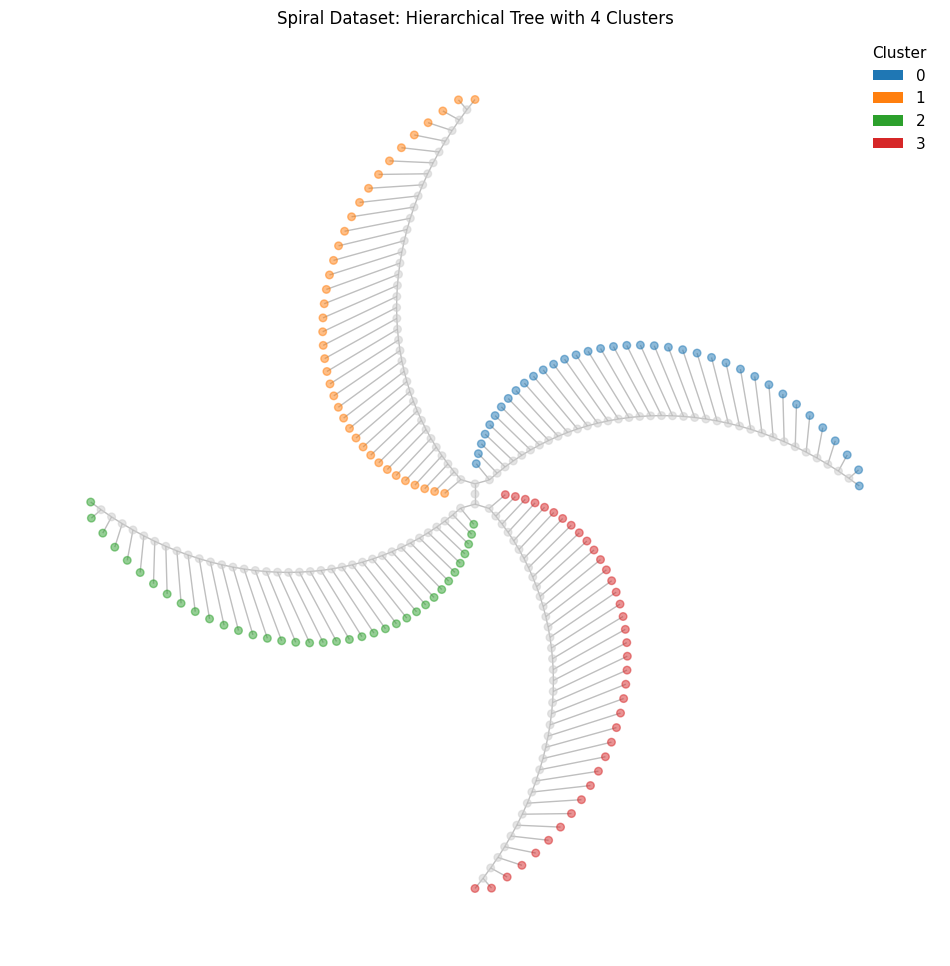

✓ Tree visualization complete


<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize Cluster Tree Structure

# Debug: Check color mapping
from kl_clustering_analysis.plot.cluster_color_mapping import build_cluster_color_spec

print("\n" + "="*60)
print("DEBUG: Cluster Color Mapping")
print("="*60)
print(f"Number of clusters: {result_spiral['num_clusters']}")

spec = build_cluster_color_spec(
    result_spiral['num_clusters'], 
    base_cmap='viridis', 
    unassigned_color="#CCCCCC"
)


print("Generating tree visualization...")
fig_tree, ax_tree = plot_tree_with_clusters(
    tree=tree_spiral,
    decomposition_results=result_spiral,
    results_df=results_df_spiral,
    figsize=(12, 12),
    node_size=30,
    font_size=12,
    title=f"Spiral Dataset: Hierarchical Tree with {result_spiral['num_clusters']} Clusters",
    colormap='tab10',  # Changed from 'viridis' to 'tab10' for better distinction
    show=True
)

# Save tree visualization
plt.savefig('../cluster_tree_plots/spiral_tree_structure.png', dpi=150, bbox_inches='tight')
print("✓ Tree visualization complete")


In [19]:
# Save Results to CSV

current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_file = f"../results/spiral_clustering_results_{current_date}.csv"

# Create results directory if it doesn't exist
os.makedirs('../results', exist_ok=True)

# Save the report
report_spiral.to_csv(results_file)

print(f"✓ Results saved:")
print(f"  - File: {results_file}")
print(f"  - Visualization: ../cluster_tree_plots/spiral_clustering_test.png")
print(f"\n{'='*60}")
print(f"Test completed successfully!")
print(f"{'='*60}")


✓ Results saved:
  - File: ../results/spiral_clustering_results_2025-12-17_13-19-04.csv
  - Visualization: ../cluster_tree_plots/spiral_clustering_test.png

Test completed successfully!
